Aqui mais testes foram feitos com a ResNet50, VGG16 e DNet121, mas agora corrigindo um bug relacionado com as predicoes do modelo, que estava arredondando os resultados para 0. Isso ocorre porque a saida e sigmoid, entao estara entre 0 e 1. O python automaticamente estava arredondando tudo para zero e, por esse motivo, havia a discrepancia entre os valores do model.evaluate e o model.predict.

In [1]:
import setuptools.dist
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121, ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.pylab as plt
import pandas as pd
import os
import shutil
import numpy as np
import seaborn as sns

2024-06-19 18:05:20.556484: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 18:05:21.705421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Função para visualização
def plot_image_counts2(folder_path):
    #Contadores pra plotar
    counts = {'cancer_type': 0, 'normal': 0}

    #Vai olhar os folders
    total_images = 0
    for class_name in counts.keys():
        class_path = os.path.join(folder_path, class_name)
        if os.path.exists(class_path):
            class_count = len(os.listdir(class_path))
            counts[class_name] = class_count
            total_images += class_count

    #Cálculo da porcentagem
    percentages = {class_name: count / total_images * 100 for class_name, count in counts.items()}

    #Plot dos gráficos
    plt.figure(figsize=(10, 6))
    plt.bar(percentages.keys(), percentages.values(), color=['blue',  'red'])
    plt.xlabel('Classe')
    plt.ylabel('Porcentagem')
    plt.title('Porcentagem de imagens em cada classe')
    plt.show()

    #Tabelinha
    df = pd.DataFrame({'Quantidade': counts.values(), 'Porcentagem': percentages.values()}, index=counts.keys())
    print("Tabela quantidade-porcentagem:")
    print(df)

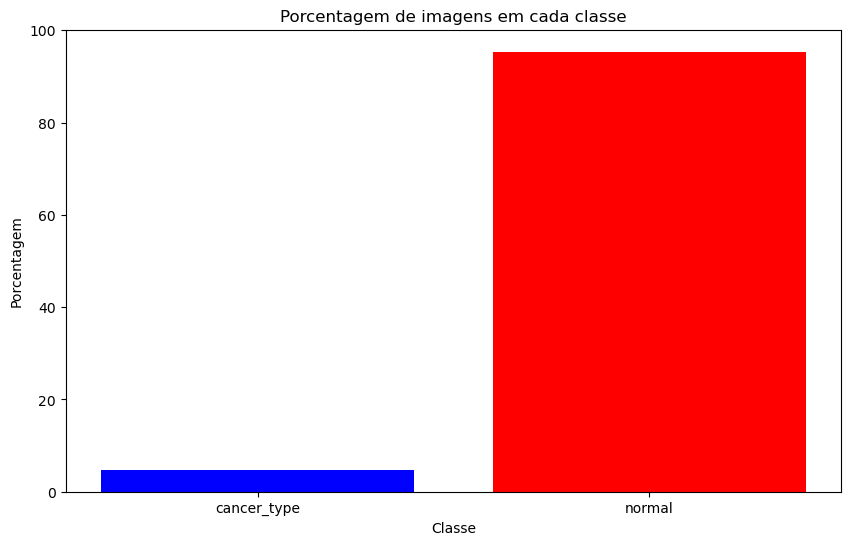

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type         200     4.641448
normal             4109    95.358552


In [3]:
#Train set binário sem data augmentation
folder_path = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/train'
plot_image_counts2(folder_path)

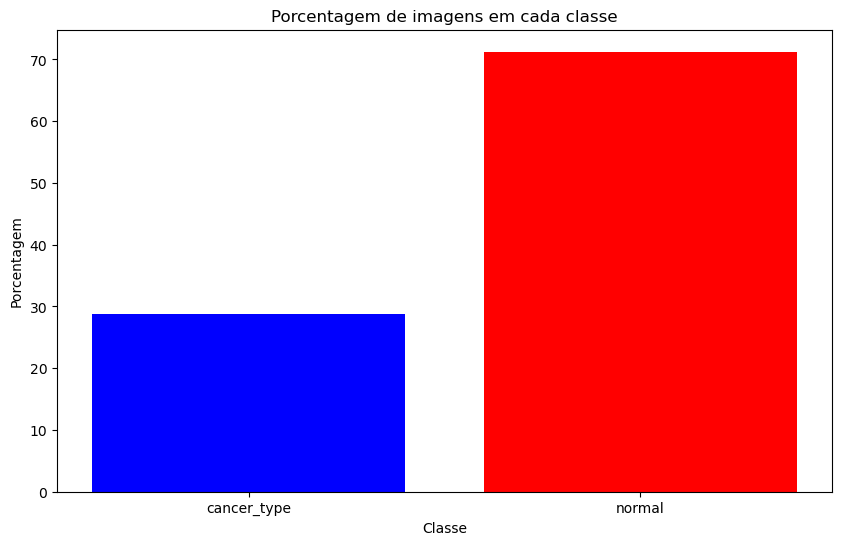

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type         121    28.741093
normal              300    71.258907


In [4]:
#Test set binário
folder_path = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/test'
plot_image_counts2(folder_path)

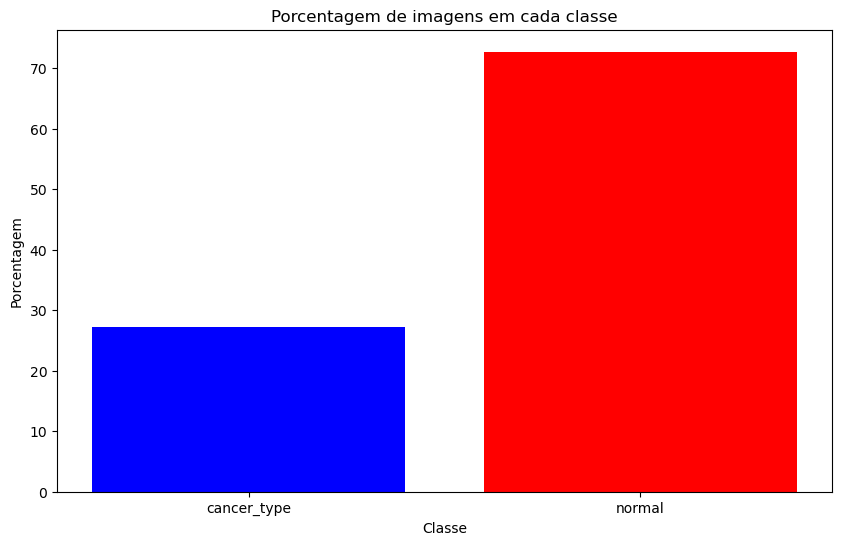

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type          75    27.272727
normal              200    72.727273


In [5]:
#Val set binário
folder_path = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/val'
plot_image_counts2(folder_path)

In [2]:
#Diretórios
train_dir = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/train'
val_dir = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/val'
test_dir = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/test'

#Set das dimensões
img_width, img_height = 1890//4, 2457//4 
input_shape = (img_width, img_height, 3)

#Batch size
batch_size = 16

#CLasses
num_classes = 2

In [3]:
#Data generators
#train_datagen = ImageDataGenerator(rescale=1./255)
#val_datagen = ImageDataGenerator(rescale=1./255)
#test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
val_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False)

Found 4309 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 421 images belonging to 2 classes.


In [4]:
#Transfer learning com a resnet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 2 classes
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid') 
])

total = 200 + 4109
weight_for_0 = (1 / 200) * (total / 2.0)
weight_for_1 = (1 / 4109) * (total / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}

In [5]:
#lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001, verbose=1)
adam = Adam(learning_rate=0.0005)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
#FAZER DEPOIS COM 0.0001

In [6]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose = 1, restore_best_weights=True)

In [7]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping])

Epoch 1/100


/home/breno/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


270/270 ━━━━━━━━━━━━━━━━━━━━ 981s 4s/step - accuracy: 0.7748 - loss: 13.3648 - val_accuracy: 0.6582 - val_loss: 39.3278
Epoch 2/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 963s 4s/step - accuracy: 0.9209 - loss: 4.8205 - val_accuracy: 0.6691 - val_loss: 39.6080
Epoch 3/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 983s 4s/step - accuracy: 0.9482 - loss: 3.0515 - val_accuracy: 0.7382 - val_loss: 69.8834
Epoch 4/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 965s 4s/step - accuracy: 0.9800 - loss: 0.8292 - val_accuracy: 0.7091 - val_loss: 55.5484
Epoch 5/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 964s 4s/step - accuracy: 0.9837 - loss: 0.5405 - val_accuracy: 0.6727 - val_loss: 46.3938
Epoch 6/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 964s 4s/step - accuracy: 0.9828 - loss: 0.6297 - val_accuracy: 0.7345 - val_loss: 97.6982
Epoch 7/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 965s 4s/step - accuracy: 0.9986 - loss: 0.0061 - val_accuracy: 0.7273 - val_loss: 100.9637
Epoch 8/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 964s 4s/step - accuracy: 0.9971 - loss: 0.1180 - val

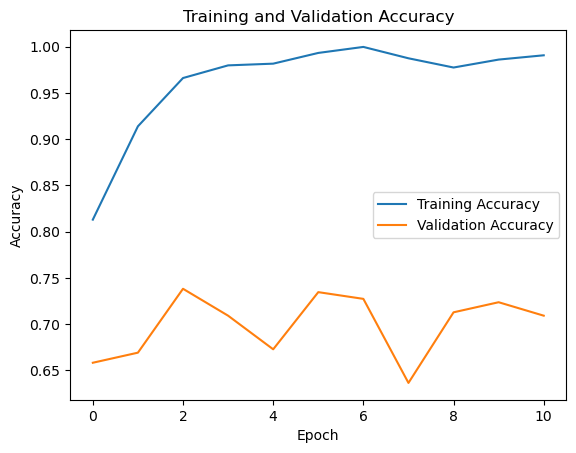

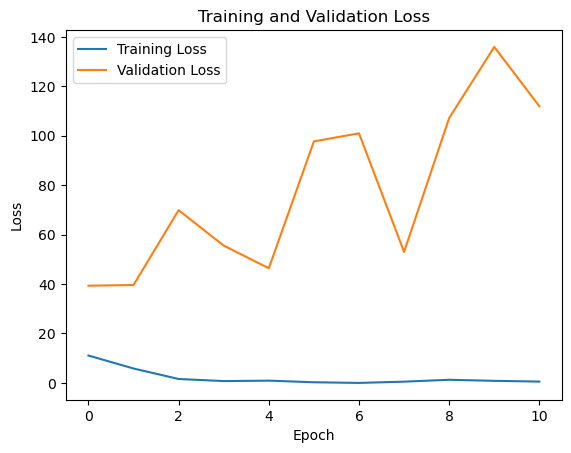

In [8]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.8739 - loss: 6.9685
Test Accuracy: 89.31%
Test Loss: 7.0634


In [10]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
#predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = (predictions > 0.5).astype(int).flatten()
predicted_labels

27/27 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [11]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

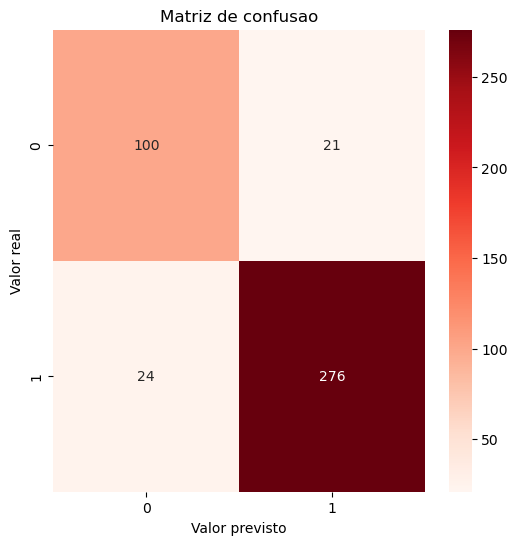

In [12]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [13]:
accuracy_from_confusion = np.trace(confusion) / np.sum(confusion)
print(f'Precisao da matriz de confusao: {accuracy_from_confusion * 100:.2f}%')

Precisao da matriz de confusao: 89.31%


In [2]:
#True negative, false positive, false negative, true positive.
#TP, FN, FP, TN = confusion.ravel()

#Sensitivity a partir da definicao
#sensitivity = TP / (TP + FN)
print(100/(100+21))

#Specifity da definicao
#specificity = TN / (TN + FP)
print(276/(276+24))


0.8264462809917356
0.92


In [14]:
#Data generators

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#train_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
#val_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
#test_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False)

Found 4309 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 421 images belonging to 2 classes.


In [15]:
#Transfer learning com a densenet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 2 classes
for layer in base_model.layers:
    layer.trainable = False

#Mais simples possivel - apenas com uso do softmax final
model = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid') 
])

total = 200 + 4109
weight_for_0 = (1 / 200) * (total / 2.0)
weight_for_1 = (1 / 4109) * (total / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}


In [16]:
#Compilar o modelo
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose = 1, restore_best_weights=True)

In [18]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping])

Epoch 1/100


/home/breno/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


270/270 ━━━━━━━━━━━━━━━━━━━━ 1059s 4s/step - accuracy: 0.7185 - loss: 9.7012 - val_accuracy: 0.6000 - val_loss: 14.5756
Epoch 2/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1041s 4s/step - accuracy: 0.8751 - loss: 2.9489 - val_accuracy: 0.6436 - val_loss: 17.8538
Epoch 3/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1044s 4s/step - accuracy: 0.9514 - loss: 0.9572 - val_accuracy: 0.6655 - val_loss: 22.2035
Epoch 4/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1042s 4s/step - accuracy: 0.9555 - loss: 1.2703 - val_accuracy: 0.6727 - val_loss: 25.5820
Epoch 5/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1044s 4s/step - accuracy: 0.9756 - loss: 0.4711 - val_accuracy: 0.7236 - val_loss: 46.7817
Epoch 6/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1045s 4s/step - accuracy: 0.9807 - loss: 0.5491 - val_accuracy: 0.6618 - val_loss: 23.8802
Epoch 7/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1044s 4s/step - accuracy: 0.9719 - loss: 0.7257 - val_accuracy: 0.7273 - val_loss: 55.2479
Epoch 8/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1045s 4s/step - accuracy: 0.9841 - loss: 0.4985

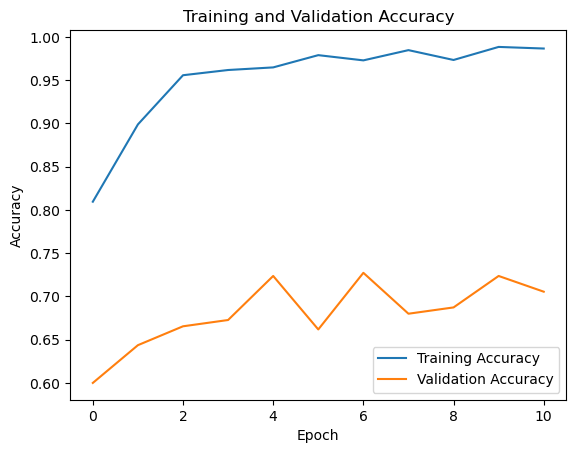

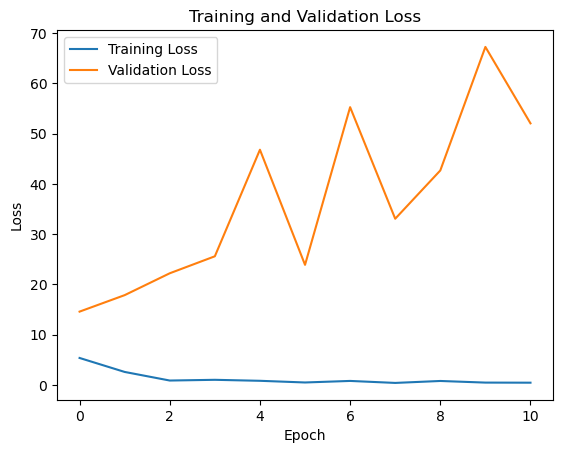

In [19]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.8487 - loss: 3.7096
Test Accuracy: 76.48%
Test Loss: 5.5162


In [21]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
#predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = (predictions > 0.5).astype(int).flatten()
predicted_labels

27/27 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,

In [22]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

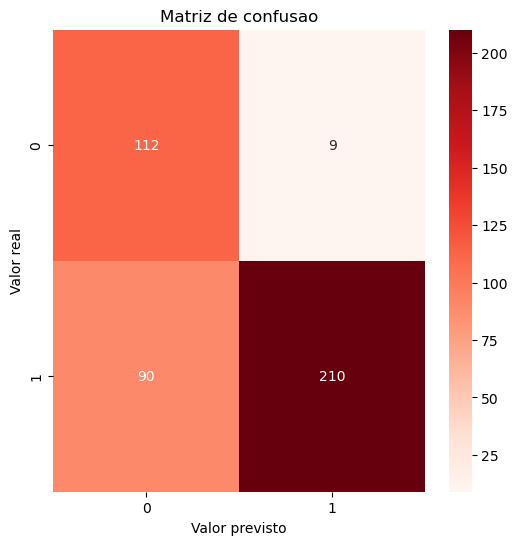

In [23]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [24]:
accuracy_from_confusion = np.trace(confusion) / np.sum(confusion)
print(f'Precisao da matriz de confusao: {accuracy_from_confusion * 100:.2f}%')

Precisao da matriz de confusao: 76.48%


In [3]:
#True negative, false positive, false negative, true positive.
#TP, FN, FP, TN = confusion.ravel()

#Sensitivity a partir da definicao
#sensitivity = TP / (TP + FN)
print(112/(112+9))

#Specifity da definicao
#specificity = TN / (TN + FP)
print(210/(210+90))


0.9256198347107438
0.7


In [25]:
#Transfer learning com a densenet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 2 classes
for layer in base_model.layers:
    layer.trainable = False

#Mais simples possivel - apenas com uso do softmax final
model = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid') 
])

total = 200 + 4109
weight_for_0 = (1 / 200) * (total / 2.0)
weight_for_1 = (1 / 4109) * (total / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}

In [26]:
#Compilar o modelo
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose = 1, restore_best_weights=True)

In [28]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping])

Epoch 1/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2050s 8s/step - accuracy: 0.6169 - loss: 2.0685 - val_accuracy: 0.7273 - val_loss: 2.8102
Epoch 2/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2048s 8s/step - accuracy: 0.8759 - loss: 0.5325 - val_accuracy: 0.7309 - val_loss: 2.9738
Epoch 3/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2046s 8s/step - accuracy: 0.9613 - loss: 0.1374 - val_accuracy: 0.7200 - val_loss: 2.4967
Epoch 4/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2047s 8s/step - accuracy: 0.8995 - loss: 0.4803 - val_accuracy: 0.7345 - val_loss: 5.1750
Epoch 5/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2047s 8s/step - accuracy: 0.9338 - loss: 0.3812 - val_accuracy: 0.7309 - val_loss: 5.1816
Epoch 6/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2046s 8s/step - accuracy: 0.9692 - loss: 0.1131 - val_accuracy: 0.7236 - val_loss: 4.3345
Epoch 7/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2048s 8s/step - accuracy: 0.9868 - loss: 0.0331 - val_accuracy: 0.7345 - val_loss: 4.8606
Epoch 8/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2047s 8s/step - accuracy: 0.9955 - loss: 0

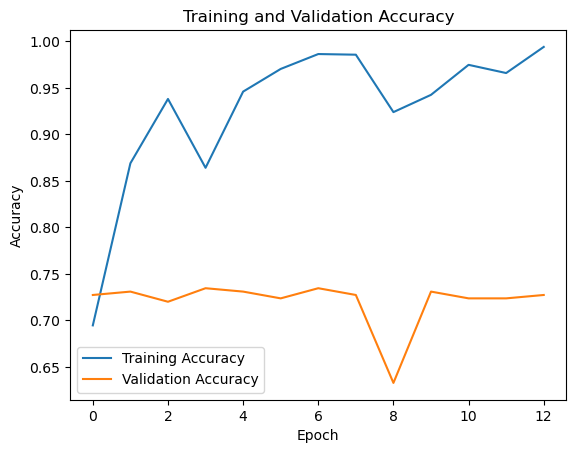

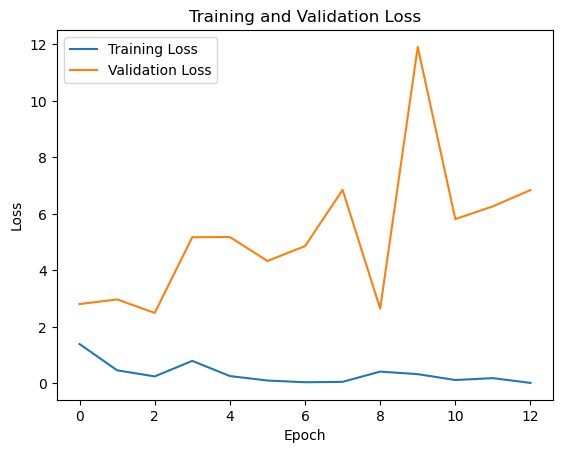

In [29]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 188s 7s/step - accuracy: 0.8793 - loss: 0.6106
Test Accuracy: 90.50%
Test Loss: 0.3818


In [31]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
#predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = (predictions > 0.5).astype(int).flatten()
predicted_labels

27/27 ━━━━━━━━━━━━━━━━━━━━ 189s 7s/step


array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [32]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

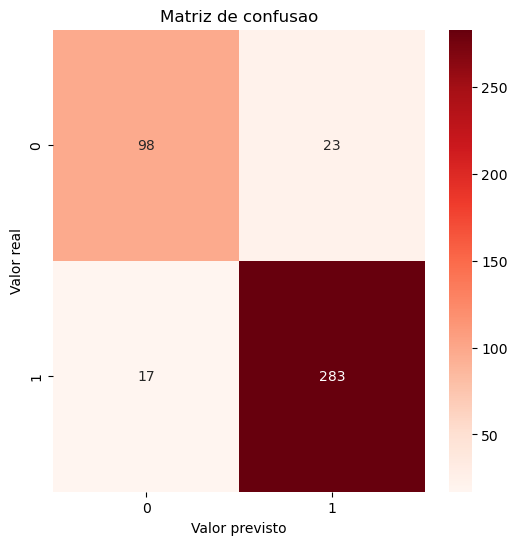

In [33]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [34]:
accuracy_from_confusion = np.trace(confusion) / np.sum(confusion)
print(f'Precisao da matriz de confusao: {accuracy_from_confusion * 100:.2f}%')

Precisao da matriz de confusao: 90.50%


In [4]:
#True negative, false positive, false negative, true positive.
#TP, FN, FP, TN = confusion.ravel()

#Sensitivity a partir da definicao
#sensitivity = TP / (TP + FN)
print(98/(98+23))

#Specifity da definicao
#specificity = TN / (TN + FP)
print(283/(283+17))


0.8099173553719008
0.9433333333333334


A partir dos resultados, percebe-se que o modelo esta indo bem no teste, pois chega em um overfitting, mas muito mal na validacao em todos os modelos. Por algum motivo, todos os modelos tambem estao indo bem no teste.